# 6. Gyakorlat: Dupla mély $Q$-tanulás
## Könyvtárak

In [1]:
import gym
import random 
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import deque
from collections import namedtuple

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns

mpl.rc('animation', html='jshtml')

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings('ignore')

## Vizualizációs függvények

In [2]:
# Jeleneti változó beállítása
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

# Szekvenciális képkockák lejátszása egymás után
def plot_animation(frames, repeat=True, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

# Egy epizód lejátszása egy neurális hálózattal
def render_policy_net(agent, n_max_steps=500, seed=42, done_close=True, epsilon=0):
    env = gym.make('LunarLander-v2', render_mode='rgb_array')
    s = env.reset()[0]
    frames = []
    rewards = []
    for step in range(n_max_steps):
        a = agent.act(s)
        sp, r, done, info, _ = env.step(a) # Execute step
        rewards.append(r)
        frames.append(env.render())
        s = sp
        if(done_close and done):
            break

    env.close()
    return frames, rewards

# Jutalmak ábrázolása
def plot_rewards(rewards, episode=True):
    n = len(rewards)
    if(episode):
        df = pd.DataFrame({'Rewards': rewards, 'Step': np.arange(n)})
        plt.figure(figsize=(6, 6))
        sns.lineplot(data=df, x='Step', y='Rewards').set(title="Jutalom "+str(n)+" lépés alatt:")
        plt.show()
    else:
        df = pd.DataFrame({'Rewards': rewards, 'Epoch': np.arange(n)})
        plt.figure(figsize=(6, 6))
        sns.lineplot(data=df, x='Epoch', y='Rewards').set(title="Jutalom "+str(n)+" epizód alatt")
        plt.show()

---
## $Q$-hálózat 

In [3]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size): # Define the architecture
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
        
    def forward(self, state): # Get predictions from the layers
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.fc3(x)

---
## Tapasztalat visszajátszás

In [4]:
class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen = buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['s', 'a', 'r', 'sp', 'done'])
    
    def add(self, s, a, r, sp, done):
        e = self.experience(s, a, r, sp, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)  # Mintavétel egyenletes eloszlással

        states = torch.from_numpy(np.vstack([e.s for e in experiences if e is not None])).float()
        actions = torch.from_numpy(np.vstack([e.a for e in experiences if e is not None])).long()
        rewards = torch.from_numpy(np.vstack([e.r for e in experiences if e is not None])).float()
        next_states = torch.from_numpy(np.vstack([e.sp for e in experiences if e is not None])).float()
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float()
  
        return states, actions, rewards, next_states, dones

    def __len__(self):
        return len(self.memory)

---
## Ügynök

In [5]:
class Agent():
    def __init__(self, state_size, action_size, buffer_size, batch_size, update_every, gamma, alpha, tau):
        self.tau = tau
        self.gamma = gamma
        self.alpha = alpha
        self.t_step = 0
        self.mse_track = []
        self.batch_size = batch_size
        self.state_size = state_size
        self.buffer_size = buffer_size
        self.action_size = action_size
        self.update_every = update_every
        self.local_model_name = 'checkpoint_DDQN_local.pth'
        self.target_model_name = 'checkpoint_DDQN_target.pth'
        
        self.qnetwork_local = QNetwork(state_size, action_size)  # Lokális hálózat (minden lépésben)
        self.qnetwork_target = QNetwork(state_size, action_size)  # Célhálózat (minden update_every lépésben)
        self.memory = ReplayBuffer(action_size, self.buffer_size, self.batch_size)  # Tapasztalat visszajátszás
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = self.alpha)  # Optimalizáló a neurális hálózathoz
    
    def step(self, s, a, r, sp, done):
        self.memory.add(s, a, r, sp, done) # Save experience in replay memory
        self.t_step = (self.t_step + 1) % self.update_every
        
        if self.t_step == 0 and len(self.memory) > self.batch_size:  # Ha van elég tapasztalat a memóriában tanulási lépés végrehajtása
            experiences = self.memory.sample()
            self.learn(experiences, self.gamma)

    def act(self, s, eps=0.):  # Cselekvés választása az állapot alapján
        s = torch.from_numpy(s).float().unsqueeze(0)
        self.qnetwork_local.eval()  # Hálózat átkapcsolása kiértékelési módra
        with torch.no_grad():  # Gradiensek nélküli művelet indítása
            action_values = self.qnetwork_local(s)
        self.qnetwork_local.train()  # Hálózat tanító módba kapcsolása

        p = np.random.random()
        if p < eps:  # Epszilon-mohó cselekvés választás
            return random.choice(np.arange(self.action_size))  # Véletlen cselekvés
        else:
            return np.argmax(action_values.cpu().data.numpy())  # Mohó cselekvés

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences  # Tapasztalat miniköteg kicsomagolása

        # Q-értékek kiszámítása az aktuális és következő állapotból
        q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        q_targets = rewards + gamma * q_targets_next * (1 - dones)  # Következő állapot Q-értékeinek kiszámítása
        q_expected = self.qnetwork_local(states).gather(1, actions)  # Aktuális állapot Q-értékeinek kiszámítása
        
        # Költség kiszámítása
        loss = F.mse_loss(q_expected, q_targets)
        self.mse_track.append(loss)  # Költség követési struktúrához való hozzáfűzése
        self.optimizer.zero_grad()  # Gradiensek kinullázása a hálózaton
        loss.backward()  # Gradiensek visszacsatolása a hálózatba
        self.optimizer.step()  # Lépés az optimalizálóval

        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)  # Célhálózat frissítése Polyak átlagolással

    def soft_update(self, local_model, target_model, tau):  # Paraméterek másolása Polyak átlagolással
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

    def save_model(self):
        torch.save(self.qnetwork_local.state_dict(), self.local_model_name)  # Lokális modell mentése
        torch.save(self.qnetwork_target.state_dict(), self.target_model_name)  # Cél modell mentése

---
## Tanítás

In [6]:
tau = 1e-3  # Polyak átlagolás paramétere
max_i = 3000  # Epizódok maximális száma
alpha = 5e-4  # Tanulási sebesség 
gamma = 0.99  # Diszkontálási faktor
max_t = 1000  # Egy epizódon belüli lépésszám
scores = []  # Jutalmak nyomon követése
eps_end = 0.01  # Felfedezési ráta végső értéke
eps_decay = 0.995  # Felfedezési ráta párologtatási együtthatója
eps_start = 1.0  # Felfedezési ráta kezdőértéke
batch_size = 64  # Kötegméret a tapasztalat visszajátszáshoz
buffer_size = int(1e5)  # Tapasztalat visszajátszás maximális mérete
update_every = 4  # Milyen gyakran frissüljön a célhálózat
scores_window = deque(maxlen = 100) # Keep track of the last 100 iterations
eps = eps_start  # Felfedezési ráta kezdőértékének megadása

env_name = 'LunarLander-v2'
env = gym.make(env_name)
print('Környezet : ', env.observation_space.shape)
print('Cselekvések száma: ', env.action_space.n)

agent = Agent(state_size = env.observation_space.shape[0], 
              action_size = env.action_space.n,
              buffer_size = buffer_size,
              batch_size = batch_size,
              update_every = update_every,
              gamma = gamma,
              alpha = alpha,
              tau = tau)

Környezet :  (8,)
Cselekvések száma:  4


In [7]:
for i in range(1, max_i+1):  # Iteráció minden epizódra
    s = env.reset()[0]
    r_sum = 0
    for t in range(max_t):
        a = agent.act(s, eps)  # Cselekvés választása az aktuális állapot alapján
        sp, r, done, info, _ = env.step(a)  # Jutalom és következő állapot megfigyelése
        agent.step(s, a, r, sp, done)  # Ügynök frissítése
        s = sp
        r_sum += r
        
        if(done):
            break

    scores_window.append(r_sum)  # Legutóbbi kumulált jutalom elmentése
    scores.append(r_sum)  # Legutóbbi kumulált jutalom hozzáfűzése az összes jutalomhoz
    eps = max(eps_end, eps_decay * eps)  # Epszilon párologtatása
    
    if i % 100 == 0:  # Minden 100 epizódban információ a tanulásól
        print(f'Epizód: {i}, Átlagos jutalom: {np.mean(scores_window)}')

    if np.mean(scores_window) >= 200:  # A feladat megoldottnak tekinthető ha a jutalom 200 felett van
        print(f'Környezet megolva {i} epizód alatt')
        print(f'Átlagos jutalom: {np.mean(scores_window)}')
        agent.save_model()
        print('Modellek mentése sikeres')
        break


Epizód: 100, Átlagos jutalom: -177.62426826574625
Epizód: 200, Átlagos jutalom: -118.44734775362075
Epizód: 300, Átlagos jutalom: -91.34221789228437
Epizód: 400, Átlagos jutalom: -52.29122450837781
Epizód: 500, Átlagos jutalom: -9.984388192250501
Epizód: 600, Átlagos jutalom: -7.9221064506733505
Epizód: 700, Átlagos jutalom: 151.55429091381703
Epizód: 800, Átlagos jutalom: 196.49806402625683
Környezet megolva 812 epizód alatt
Átlagos jutalom: 200.15605401324382
Modellek mentése sikeres


---
## Kiértékelés
### Jutalmak ábrázolása

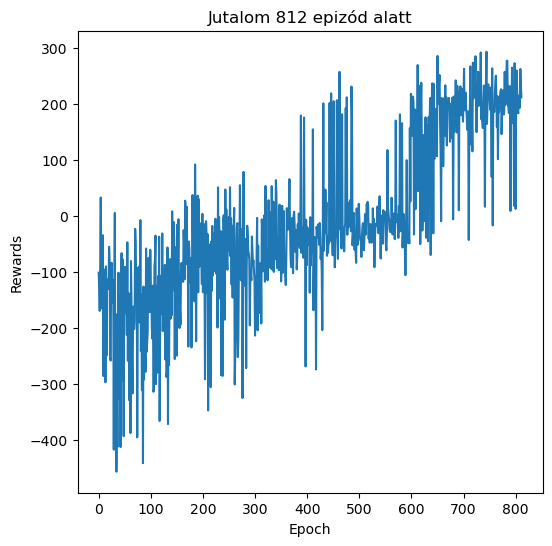

In [8]:
plot_rewards(scores, episode=False)

### Átlagos jutalmak

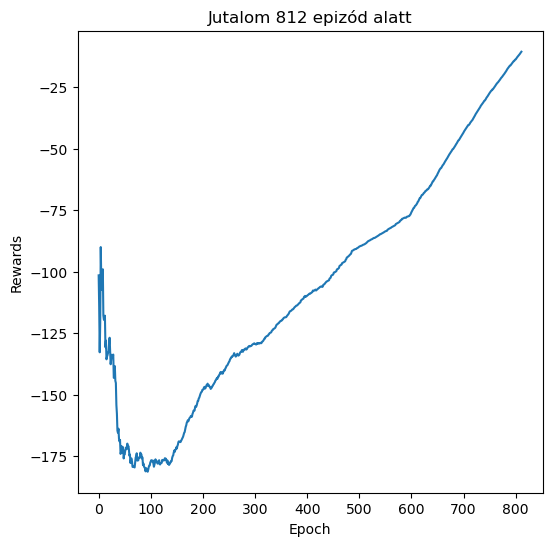

In [9]:
average_rewards = np.cumsum(scores) / (np.arange(len(scores)) + 1)
plot_rewards(average_rewards, episode=False)

### Egy epizód lejátszása

In [10]:
frames, rewards = render_policy_net(agent)
plot_animation(frames)

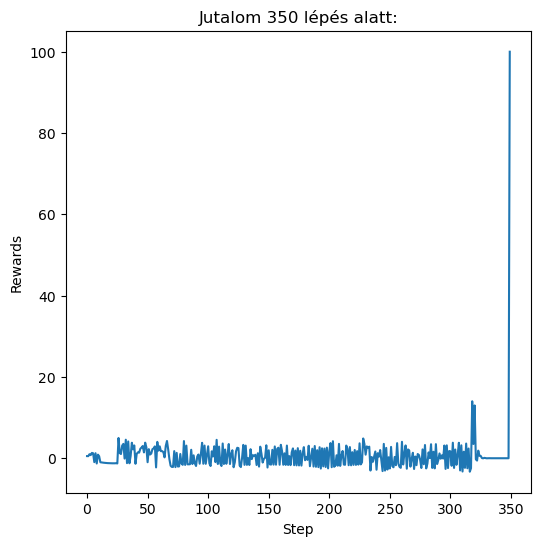

In [11]:
plot_rewards(rewards)

### Hiba ábrázolása

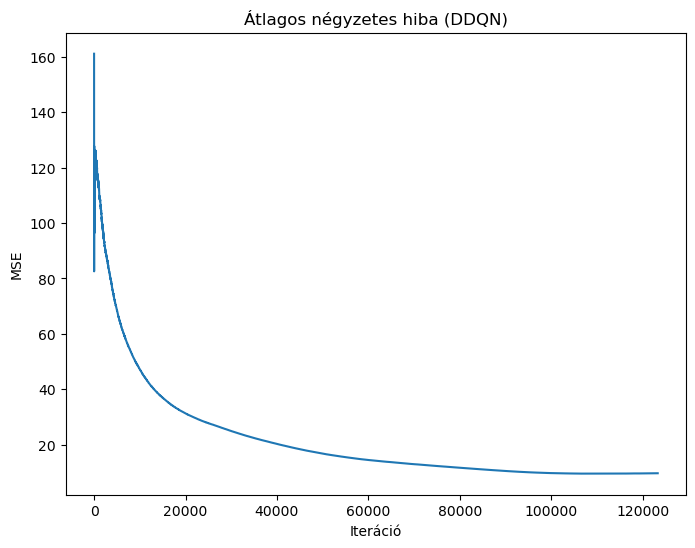

In [12]:
errors = [np.float64(x) for x in agent.mse_track]
mean_errors = [np.mean(errors[:x+1]) for x in range(len(errors))]

df = pd.DataFrame({"Iteration":np.arange(len(agent.mse_track))+1, "MSE":mean_errors})
df.to_csv('MSE_DDQN.csv', sep=',', index=False)
plt.figure(figsize=(8,6))
plt.title("Átlagos négyzetes hiba (DDQN)")
ax = sns.lineplot(x="Iteration", y="MSE", data=df)
plt.xlabel('Iteráció')
plt.ylabel('MSE')
plt.show()